In [123]:
!pip install fuzzywuzzy

In [26]:
import pandas as pd
import numpy as np

import requests
from requests.auth import HTTPBasicAuth
import string
import warnings
# warnings.filterwarnings('ignore')
import json

# for fuzzy matching
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [2]:
def get_url_list():
    
    url_list = []
    main_url = 'https://www.thecocktaildb.com/api/json/v1/1/search.php?f='
    
    for i in string.printable:
        url_list.append(main_url+i)
        
    return url_list

In [3]:
def scrape_cocktail_list():
    
    cocktail_list = []
    url_list = get_url_list()
    
    for i in url_list:
        try:
            r = requests.get(i, verify=False)
            cocktail_list.append(r)
        except:
            pass
    return cocktail_list

In [4]:
def get_ingredients(cocktail_dict):

    ingredient = cocktail_dict['strIngredient1']
    i = 2

    ingredient_list = ""

    while ingredient:

        ingredient_list = ingredient + ", " + ingredient_list
        ingredient = cocktail_dict['strIngredient'+str(i)]
  
        i = i+1

    return ingredient_list

In [5]:
# scraping does not work due to permission error
# get_cocktail_list()

In [6]:
# Opening JSON file
f = open('cocktail_list.json')
  
# returns JSON object as a dictionary
data = json.load(f)
cocktails_list = []

for cocktail_dict in data['drinks']: 

        cocktail = {}
        cocktail['drink'] = cocktail_dict['strDrink']
        cocktail['ingredients'] = get_ingredients(cocktail_dict)
        cocktail['instructions'] = cocktail_dict['strInstructions']

        cocktails_list.append(cocktail)

In [7]:
cocktails_list

[{'drink': 'A1',
  'ingredients': 'Grenadine, Lemon Juice, Grand Marnier, Gin, ',
  'instructions': 'Pour all ingredients into a cocktail shaker, mix and serve over ice into a chilled glass.'},
 {'drink': 'ABC',
  'ingredients': 'Cognac, Baileys irish cream, Amaretto, ',
  'instructions': 'Layered in a shot glass.'},
 {'drink': 'Ace',
  'ingredients': 'Egg White, Milk, Heavy cream, Grenadine, Gin, ',
  'instructions': 'Shake all the ingredients in a cocktail shaker and ice then strain in a cold glass.'},
 {'drink': 'ACID',
  'ingredients': 'Wild Turkey, 151 proof rum, ',
  'instructions': 'Poor in the 151 first followed by the 101 served with a Coke or Dr Pepper chaser.'},
 {'drink': 'Adam',
  'ingredients': 'Grenadine, Lemon juice, Dark rum, ',
  'instructions': 'In a shaker half-filled with ice cubes, combine all of the ingredients. Shake well. Strain into a cocktail glass.'},
 {'drink': 'AT&T',
  'ingredients': 'Tonic water, Gin, Absolut Vodka, ',
  'instructions': 'Pour Vodka and G

In [8]:
cocktail_df = pd.DataFrame(cocktails_list)

In [9]:
cocktail_df.head()

,drink,ingredients,instructions
0,A1,"Grenadine, Lemon Juice, Grand Marnier, Gin,","Pour all ingredients into a cocktail shaker, m..."
1,ABC,"Cognac, Baileys irish cream, Amaretto,",Layered in a shot glass.
2,Ace,"Egg White, Milk, Heavy cream, Grenadine, Gin,",Shake all the ingredients in a cocktail shaker...
3,ACID,"Wild Turkey, 151 proof rum,",Poor in the 151 first followed by the 101 serv...
4,Adam,"Grenadine, Lemon juice, Dark rum,","In a shaker half-filled with ice cubes, combin..."


In [10]:
cocktail_df.describe()

,drink,ingredients,instructions
count,441,441,441
unique,441,437,406
top,Dark Caipirinha,"Wild Turkey, 151 proof rum,","Shake all ingredients with ice, strain into a ..."
freq,1,2,12


In [11]:
cocktail_df['drink'] = cocktail_df['drink'].str.lower().str.replace('[^\w\s]','')
cocktail_df['ingredients'] = cocktail_df['ingredients'].str.lower().str.replace('[^\w\s]','')
cocktail_df['instructions'] = cocktail_df['instructions'].str.lower().str.replace('[^\w\s]','')

In [12]:
cocktail_df.head()

,drink,ingredients,instructions
0,a1,grenadine lemon juice grand marnier gin,pour all ingredients into a cocktail shaker mi...
1,abc,cognac baileys irish cream amaretto,layered in a shot glass
2,ace,egg white milk heavy cream grenadine gin,shake all the ingredients in a cocktail shaker...
3,acid,wild turkey 151 proof rum,poor in the 151 first followed by the 101 serv...
4,adam,grenadine lemon juice dark rum,in a shaker halffilled with ice cubes combine ...


In [13]:
new_df = cocktail_df.ingredients.str.split(expand=True).stack().value_counts().reset_index()
 
new_df.columns = ['ingredient', 'frequency'] 
 
new_df.head(10)

,ingredient,frequency
0,juice,196
1,lemon,115
2,rum,97
3,sugar,95
4,gin,87
5,orange,83
6,vodka,76
7,water,66
8,lime,66
9,cream,48


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(cocktail_df['ingredients'])
arr = X.toarray()

C:\Users\joaka\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [15]:
labels = [cocktail for cocktail in cocktail_df['drink']]
# labels = [cocktail for cocktail in cocktail_df['ingredients']]

 
def create_heatmap(similarity, cmap = "YlGnBu"):
      df = pd.DataFrame(similarity)
      df.columns = labels
      df.index = labels
      fig, ax = plt.subplots(figsize=(5,5))
      sns.heatmap(df, cmap=cmap)

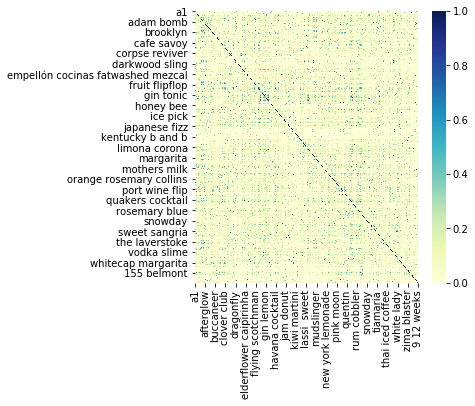

In [16]:
create_heatmap(cosine_similarity(arr))

In [17]:
similarity_table = pd.DataFrame(cosine_similarity(arr), columns=cocktail_df['drink'], index=cocktail_df['drink'])

In [18]:
for column in similarity_table.columns:
    similarity_table[column] = np.where(similarity_table[column] >= 1, 0, similarity_table[column])

In [20]:
similarity_table.head()

drink,a1,abc,ace,acid,adam,att,a j,affair,apello,avalon,...,3 wise men,3mile long island iced tea,410 gone,5050,501 blue,57 chevy with a white license plate,69 special,747,747 drink,9 12 weeks
drink,,,,,,,,,,,,,,,,,,,,,
a1,0.000000,0.000000,0.214929,0.000000,0.372224,0.090064,0.058347,0.078508,0.127279,0.124399,...,0.0,0.106973,0.0,0.650410,0.0,0.0,0.280010,0.000000,0.073074,0.035916
abc,0.000000,0.000000,0.107965,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.477527,0.000000,0.000000
ace,0.214929,0.107965,0.000000,0.000000,0.182635,0.077691,0.000000,0.000000,0.000000,0.000000,...,0.0,0.049718,0.0,0.000000,0.0,0.0,0.098253,0.109209,0.000000,0.000000
acid,0.000000,0.000000,0.000000,0.000000,0.096524,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.050549,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
adam,0.372224,0.000000,0.182635,0.096524,0.000000,0.000000,0.075352,0.101389,0.164375,0.160655,...,0.0,0.138151,0.0,0.063604,0.0,0.0,0.214522,0.000000,0.094371,0.046384


In [21]:
similar_cocktail= similarity_table.idxmax()

In [22]:
similar_cocktail['a1']

'talos coffee'

In [30]:
def similar_cocktail(initial_cocktail):
    similarity_table = pd.DataFrame(cosine_similarity(arr), columns=cocktail_df['drink'], index=cocktail_df['drink'])
    for column in similarity_table.columns:
        similarity_table[column] = np.where(similarity_table[column] >= 1, 0, similarity_table[column])
    similar_cocktail= similarity_table.idxmax()
    
    return similar_cocktail[initial_cocktail]

In [31]:
similar_cocktail('a1')

'talos coffee'

### Pickling the model file for deployment

In [23]:
import pickle

In [24]:
pickle.dump(X, open('tfidf.pkl','wb'))

In [32]:
pickle.dump(similar_cocktail, open('similar_cocktail.pkl','wb'))

In [25]:
pickled_model = pickle.load(open('tfidf.pkl','rb'))

In [33]:
pickled_rec = pickle.load(open('similar_cocktail.pkl','rb'))

In [35]:
pickled_rec('a1')

'talos coffee'